## Predicting Churn with Neural Networks

In this notebook, I attempt to build a model based on <code>Keras</code> library and train it on the same fictional telecoms company data used in other parts of this project. The code below is mainly adapted from <code>TensorFlow</code>'s [tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) on how to handle imbalanced data.

I will first train a model without taking the different class weights into account. I will then compare the results to another model that is trained with the class imbalance accounted for.

In [1]:
#loading the necessary python libraries
import pandas as pd
import numpy as np
import os
import tempfile

import seaborn as sns
sns.set(font_scale = 1.5)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#loading various libraries needed for preprocessing, modelling and evaluating
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, fbeta_score, \
                            precision_score, make_scorer, confusion_matrix, roc_curve, precision_recall_curve

import tensorflow as tf
from tensorflow import keras

In [3]:
#loading the dataset into a pandas dataframe
customer_data = pd.read_csv('../data-sources/customer-churn/customer-churn.csv')
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#applying the same naming convention to all column names
customer_data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure': 'Tenure'}, inplace=True)

In [5]:
#creating a LabelEncoder object
le = LabelEncoder()

#enoding the target variable into numerical binary
customer_data['Churn'] = le.fit_transform(customer_data['Churn'])

In [6]:
#creating a function to convert numerical binary data into categorical binary data
def ColumnTransformer(cell):
    if cell == 0:
        return 'No'
    else:
        return 'Yes'

#applying the above function to the SeniorCitizen column
customer_data['SeniorCitizen'] = customer_data['SeniorCitizen'].apply(ColumnTransformer)

In [7]:
#creating a function to shorten the vocabulary for easier visualisation
def ColumnTransformer(cell):
    if cell == 'Electronic check':
        return 'ElCh'
    elif cell == 'Mailed check':
        return 'MaCh'
    elif cell == 'Bank transfer (automatic)':
        return 'BaTr-A'
    else:
        return 'CrCa-A'
    
#applying the above function to the PaymentMethod column
customer_data['PaymentMethod'] = customer_data['PaymentMethod'].apply(ColumnTransformer)

In [8]:
#removing all the customers who have been with the company for less than a month and deleting the CustomerID column
customer_data.drop(customer_data[customer_data['Tenure'] == 0].index, inplace=True)
customer_data.drop('CustomerID', axis=1, inplace=True)

#converting TotalCharges from object to float data type
customer_data['TotalCharges'] = customer_data['TotalCharges'].astype(float)

In [9]:
#taking another look at the imbalance present in the data
print('Total: {}\n    Positive: {:.2f}\n    Negative: {:.2f}\n'.format(customer_data.shape[0],
                                                         customer_data['Churn'].value_counts(normalize=True)[1],
                                                         customer_data['Churn'].value_counts(normalize=True)[0]))

Total: 7032
    Positive: 0.27
    Negative: 0.73



In [10]:
##separating the target variable
target = customer_data.pop('Churn')

#dummifying the categorical features and removing any redundencies
customer_data_dum = pd.get_dummies(customer_data, columns=customer_data.select_dtypes(include='object').columns,
                                                   drop_first=True)

#adding the target variable back to the dummyfied data
customer_data_dum['Churn'] = target

In [11]:
#splitting the data into different train, test and validation sets
train_data, test_data = train_test_split(customer_data_dum, test_size=0.2, stratify=customer_data_dum['Churn'])
train_data, validation_data = train_test_split(train_data, test_size=0.2, stratify=train_data['Churn'])

In [12]:
#creating numpy arrays from the available labels and features
train_labels = np.array(train_data.pop('Churn'))
bool_train_labels = train_labels != 0
validation_labels = np.array(validation_data.pop('Churn'))
test_labels = np.array(test_data.pop('Churn'))

train_features = np.array(train_data)
validation_features = np.array(validation_data)
test_features = np.array(test_data)

In [13]:
#creating a StandardScaler object and standardising train, validation and test sets
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
validation_features = scaler.transform(validation_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', validation_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', validation_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (4500,)
Validation labels shape: (1125,)
Test labels shape: (1407,)
Training features shape: (4500, 30)
Validation features shape: (1125, 30)
Test features shape: (1407, 30)


/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Negative distribution')

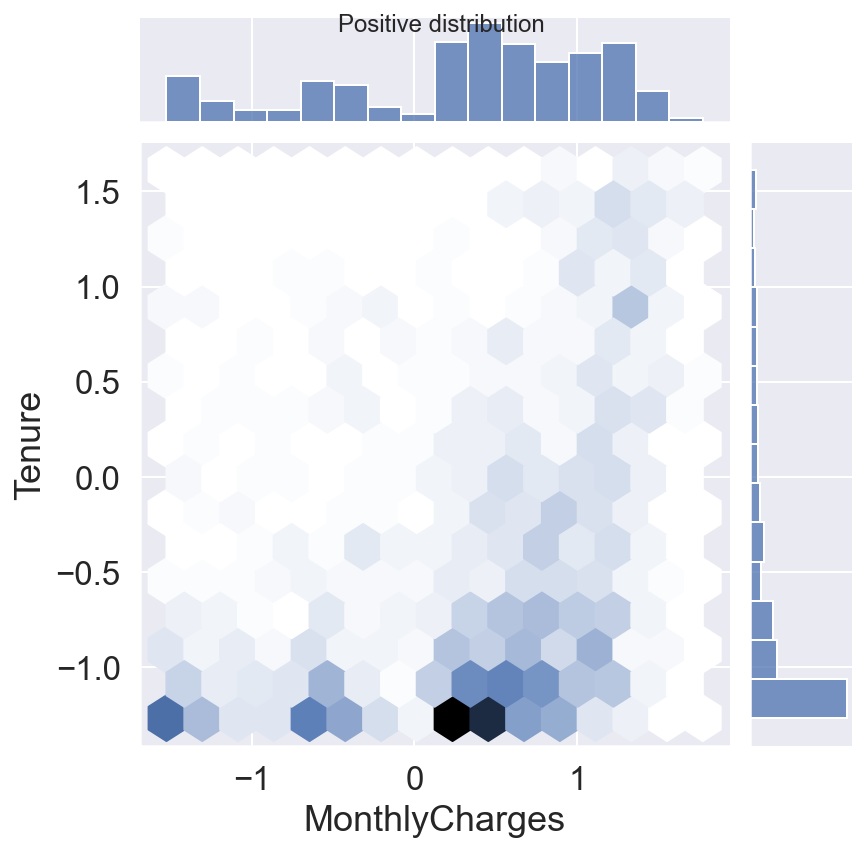

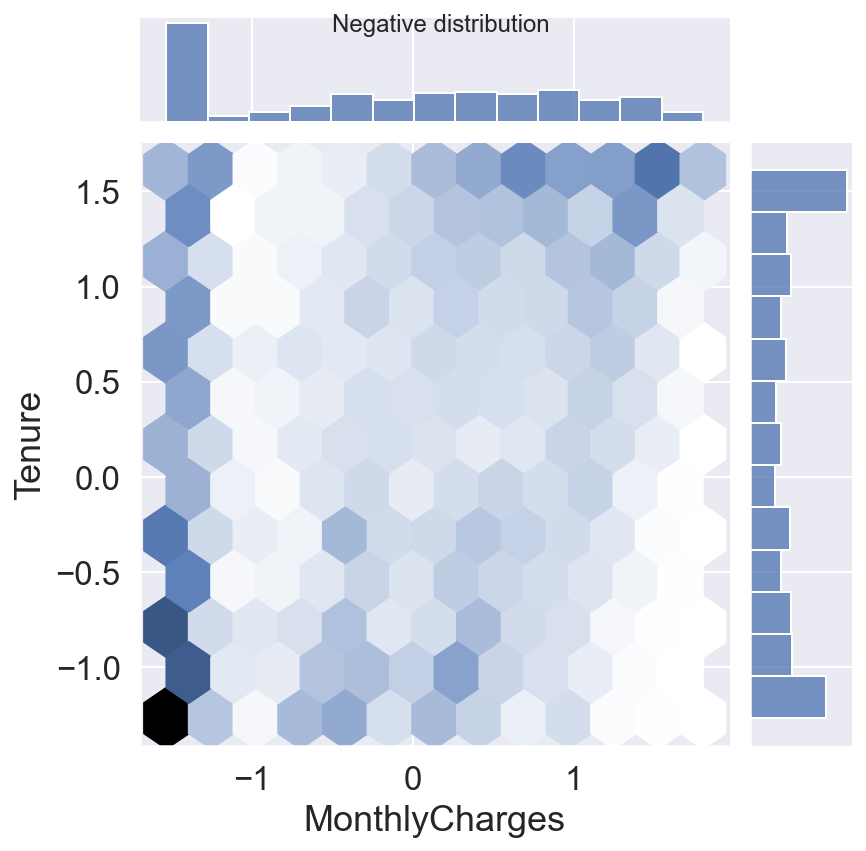

In [14]:
#separating the positive and negative churn instances into different dataframes
pos_data = pd.DataFrame(train_features[bool_train_labels], columns=train_data.columns)
neg_data = pd.DataFrame(train_features[~bool_train_labels], columns=train_data.columns)

#surveying two sample distributions 
sns.jointplot(pos_data['MonthlyCharges'], pos_data['Tenure'], kind='hex')
plt.suptitle('Positive distribution')

sns.jointplot(neg_data['MonthlyCharges'], neg_data['Tenure'], kind='hex')
plt.suptitle('Negative distribution')

#### Creating the Model and Defining the Metrics

In [15]:
#outlining the different metrics to use for model evaluation
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.AUC(name='prc', curve='PR'),]

#creating a function that creates a simple neural network with two densly connected hidden layers, two dropout layer
#for regularization, and one output layer to return the probability of churn
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([keras.layers.Dense(24, activation='relu', input_shape=(train_features.shape[-1],)),
                              keras.layers.Dropout(0.5),
                              keras.layers.Dense(16, activation='relu'),
                              keras.layers.Dropout(0.4),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer = output_bias),
                             ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
    return model

In [16]:
#defining the number of epochs and the batch size used during modelling
EPOCHS = 100
BATCH_SIZE = 150

#defining the early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc',
                                                  verbose=1,
                                                  patience=10,
                                                  mode='max',
                                                  restore_best_weights=True)

#building the model and printing out the summary
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                744       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________


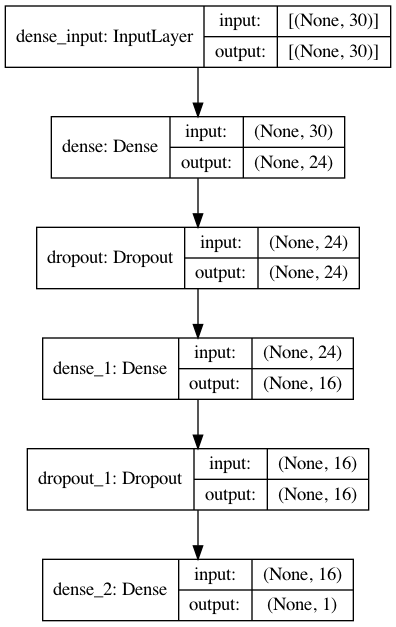

In [17]:
#plotting the model chart
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB')

#### Correcting the Initial Bias

Given the imbalanced nature of the data, we know that the automatically generated initial bias might not be great. Here, I will first check the machine generated biases and the ncompare the Loss to a another model that reflects this imbalance in its output layer.

In [18]:
#making predictions for the first 10 observations to test the model
model.predict(train_features[:10])

array([[0.23938733],
       [0.076141  ],
       [0.17113078],
       [0.3101474 ],
       [0.07156947],
       [0.15859151],
       [0.32875842],
       [0.21263808],
       [0.30544809],
       [0.3086925 ]], dtype=float32)

In [19]:
#evaluating the Loss for these few predictions
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.5600


In [20]:
#calculating the initial bias based on the present imbalance
neg, pos = np.bincount(customer_data_dum['Churn'])

total = neg + pos

initial_bias = np.log([pos/neg])
initial_bias

array([-1.01611428])

In [21]:
#inserting the new bias figure into the model and making predictions
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.485035  ],
       [0.25025254],
       [0.2566907 ],
       [0.4624975 ],
       [0.1305874 ],
       [0.399608  ],
       [0.20743889],
       [0.28900167],
       [0.34395498],
       [0.28976518]], dtype=float32)

In [22]:
#evaluating the Loss for these latest predictions
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.5915


As we can see, using the correct initial bias has reduced the Loss. Next, I will quantify how much this bias initialisation actually helps.

In [23]:
#saving the initial weights in a checkpoint file for future use
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [24]:
#creating a model and setting the initial weights to zero 
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])

#fitting the model and checking against the validation set
zero_bias_history = model.fit(train_features,
                              train_labels,
                              batch_size=BATCH_SIZE,
                              epochs=20,
                              validation_data=(validation_features, validation_labels),
                              verbose=0)

In [25]:
#creating a model with the calculated initial weights
model = make_model()
model.load_weights(initial_weights)

#fitting the model and checking against the validation set
careful_bias_history = model.fit(train_features,
                                 train_labels,
                                 batch_size=BATCH_SIZE,
                                 epochs=20,
                                 validation_data=(validation_features, validation_labels),
                                 verbose=0)

In [26]:
#creating a function to plot the loss metric over the range of epochs
def PlotLoss(history, label, color):
    plt.semilogy(history.epoch, history.history['loss'], color=color, label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=color, label='Validation ' + label, ls='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

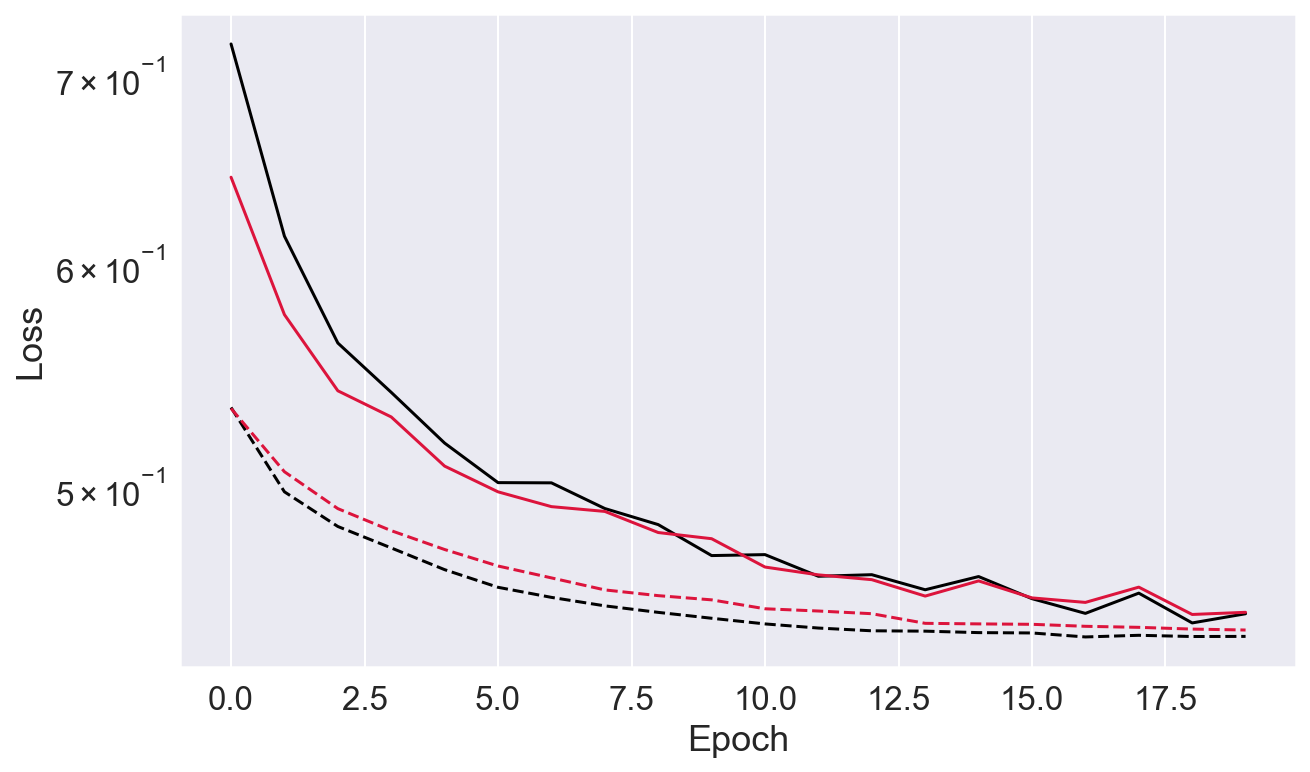

In [27]:
#plotting the loss and validation loss for each weight bias
plt.figure(figsize=(10, 6))
PlotLoss(zero_bias_history, 'Zero Bias', 'black')
PlotLoss(careful_bias_history, 'Careful Bias', 'crimson')

As we can see, the difference in this case isn't significant. However, using the correct initial weight is an important step in dealing with imbalanced data. Therefore, I will be using these initial weights from now on, regardless of their impact in this particular instance.

#### Class Weights

In this section, I will first train and evaluate a model without passing class weights, followed by training and evaluating a model that takes class weights into account.

In [28]:
#training and validating a model with initial weights and predefined number of epochs 
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(train_features,
                             train_labels,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks=[early_stopping],
                             validation_data=(validation_features, validation_labels))

Epoch 1/100
30/30 [==============================] - 2s 26ms/step - loss: 0.6440 - tp: 246.0000 - fp: 437.0000 - tn: 3693.0000 - fn: 1249.0000 - accuracy: 0.7003 - precision: 0.3602 - recall: 0.1645 - auc: 0.6201 - prc: 0.3259 - val_loss: 0.5361 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 826.0000 - val_fn: 299.0000 - val_accuracy: 0.7342 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7106 - val_prc: 0.4311
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 0.5767 - tp: 155.0000 - fp: 198.0000 - tn: 3106.0000 - fn: 1041.0000 - accuracy: 0.7247 - precision: 0.4391 - recall: 0.1296 - auc: 0.6376 - prc: 0.3637 - val_loss: 0.5104 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 826.0000 - val_fn: 299.0000 - val_accuracy: 0.7342 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7602 - val_prc: 0.4993
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 0.5417 - tp: 188.0000 - fp: 188.0000 - tn: 3116.0000

30/30 [==============================] - 0s 3ms/step - loss: 0.4538 - tp: 388.0000 - fp: 224.0000 - tn: 3080.0000 - fn: 808.0000 - accuracy: 0.7707 - precision: 0.6340 - recall: 0.3244 - auc: 0.8144 - prc: 0.5764 - val_loss: 0.4462 - val_tp: 88.0000 - val_fp: 40.0000 - val_tn: 786.0000 - val_fn: 211.0000 - val_accuracy: 0.7769 - val_precision: 0.6875 - val_recall: 0.2943 - val_auc: 0.8212 - val_prc: 0.6036
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4490 - tp: 412.0000 - fp: 220.0000 - tn: 3084.0000 - fn: 784.0000 - accuracy: 0.7769 - precision: 0.6519 - recall: 0.3445 - auc: 0.8224 - prc: 0.5824 - val_loss: 0.4451 - val_tp: 94.0000 - val_fp: 46.0000 - val_tn: 780.0000 - val_fn: 205.0000 - val_accuracy: 0.7769 - val_precision: 0.6714 - val_recall: 0.3144 - val_auc: 0.8210 - val_prc: 0.6032
Epoch 22/100
30/30 [==============================] - 0s 2ms/step - loss: 0.4456 - tp: 462.0000 - fp: 288.0000 - tn: 3016.0000 - fn: 734.0000 - accuracy: 0.7729 - prec

30/30 [==============================] - 0s 2ms/step - loss: 0.4374 - tp: 464.0000 - fp: 246.0000 - tn: 3058.0000 - fn: 732.0000 - accuracy: 0.7827 - precision: 0.6535 - recall: 0.3880 - auc: 0.8300 - prc: 0.6136 - val_loss: 0.4432 - val_tp: 106.0000 - val_fp: 53.0000 - val_tn: 773.0000 - val_fn: 193.0000 - val_accuracy: 0.7813 - val_precision: 0.6667 - val_recall: 0.3545 - val_auc: 0.8217 - val_prc: 0.6076
Epoch 40/100
30/30 [==============================] - 0s 2ms/step - loss: 0.4333 - tp: 487.0000 - fp: 243.0000 - tn: 3061.0000 - fn: 709.0000 - accuracy: 0.7884 - precision: 0.6671 - recall: 0.4072 - auc: 0.8356 - prc: 0.6184 - val_loss: 0.4417 - val_tp: 115.0000 - val_fp: 60.0000 - val_tn: 766.0000 - val_fn: 184.0000 - val_accuracy: 0.7831 - val_precision: 0.6571 - val_recall: 0.3846 - val_auc: 0.8216 - val_prc: 0.6073
Epoch 41/100
30/30 [==============================] - 0s 2ms/step - loss: 0.4334 - tp: 506.0000 - fp: 263.0000 - tn: 3041.0000 - fn: 690.0000 - accuracy: 0.7882 - pr

30/30 [==============================] - 0s 2ms/step - loss: 0.4309 - tp: 502.0000 - fp: 259.0000 - tn: 3045.0000 - fn: 694.0000 - accuracy: 0.7882 - precision: 0.6597 - recall: 0.4197 - auc: 0.8383 - prc: 0.6131 - val_loss: 0.4421 - val_tp: 115.0000 - val_fp: 61.0000 - val_tn: 765.0000 - val_fn: 184.0000 - val_accuracy: 0.7822 - val_precision: 0.6534 - val_recall: 0.3846 - val_auc: 0.8212 - val_prc: 0.6124
Epoch 59/100
30/30 [==============================] - 0s 2ms/step - loss: 0.4243 - tp: 505.0000 - fp: 259.0000 - tn: 3045.0000 - fn: 691.0000 - accuracy: 0.7889 - precision: 0.6610 - recall: 0.4222 - auc: 0.8403 - prc: 0.6275 - val_loss: 0.4421 - val_tp: 120.0000 - val_fp: 68.0000 - val_tn: 758.0000 - val_fn: 179.0000 - val_accuracy: 0.7804 - val_precision: 0.6383 - val_recall: 0.4013 - val_auc: 0.8208 - val_prc: 0.6110
Epoch 60/100
30/30 [==============================] - 0s 2ms/step - loss: 0.4261 - tp: 535.0000 - fp: 265.0000 - tn: 3039.0000 - fn: 661.0000 - accuracy: 0.7942 - pr

30/30 [==============================] - 0s 2ms/step - loss: 0.4236 - tp: 547.0000 - fp: 242.0000 - tn: 3062.0000 - fn: 649.0000 - accuracy: 0.8020 - precision: 0.6933 - recall: 0.4574 - auc: 0.8454 - prc: 0.6292 - val_loss: 0.4421 - val_tp: 122.0000 - val_fp: 69.0000 - val_tn: 757.0000 - val_fn: 177.0000 - val_accuracy: 0.7813 - val_precision: 0.6387 - val_recall: 0.4080 - val_auc: 0.8206 - val_prc: 0.6122
Epoch 78/100
30/30 [==============================] - 0s 2ms/step - loss: 0.4230 - tp: 530.0000 - fp: 274.0000 - tn: 3030.0000 - fn: 666.0000 - accuracy: 0.7911 - precision: 0.6592 - recall: 0.4431 - auc: 0.8451 - prc: 0.6342 - val_loss: 0.4416 - val_tp: 125.0000 - val_fp: 75.0000 - val_tn: 751.0000 - val_fn: 174.0000 - val_accuracy: 0.7787 - val_precision: 0.6250 - val_recall: 0.4181 - val_auc: 0.8204 - val_prc: 0.6104
Epoch 79/100
30/30 [==============================] - 0s 2ms/step - loss: 0.4223 - tp: 543.0000 - fp: 283.0000 - tn: 3021.0000 - fn: 653.0000 - accuracy: 0.7920 - pr

In [29]:
#creating a function to plot different model metrics against the number of epochs
def PlotMetrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    plt.figure(figsize=(15, 15))
    for n, metric in enumerate(metrics):
        name = metric.replace('_', ' ').capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color='black', label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], color='black', ls='--', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()

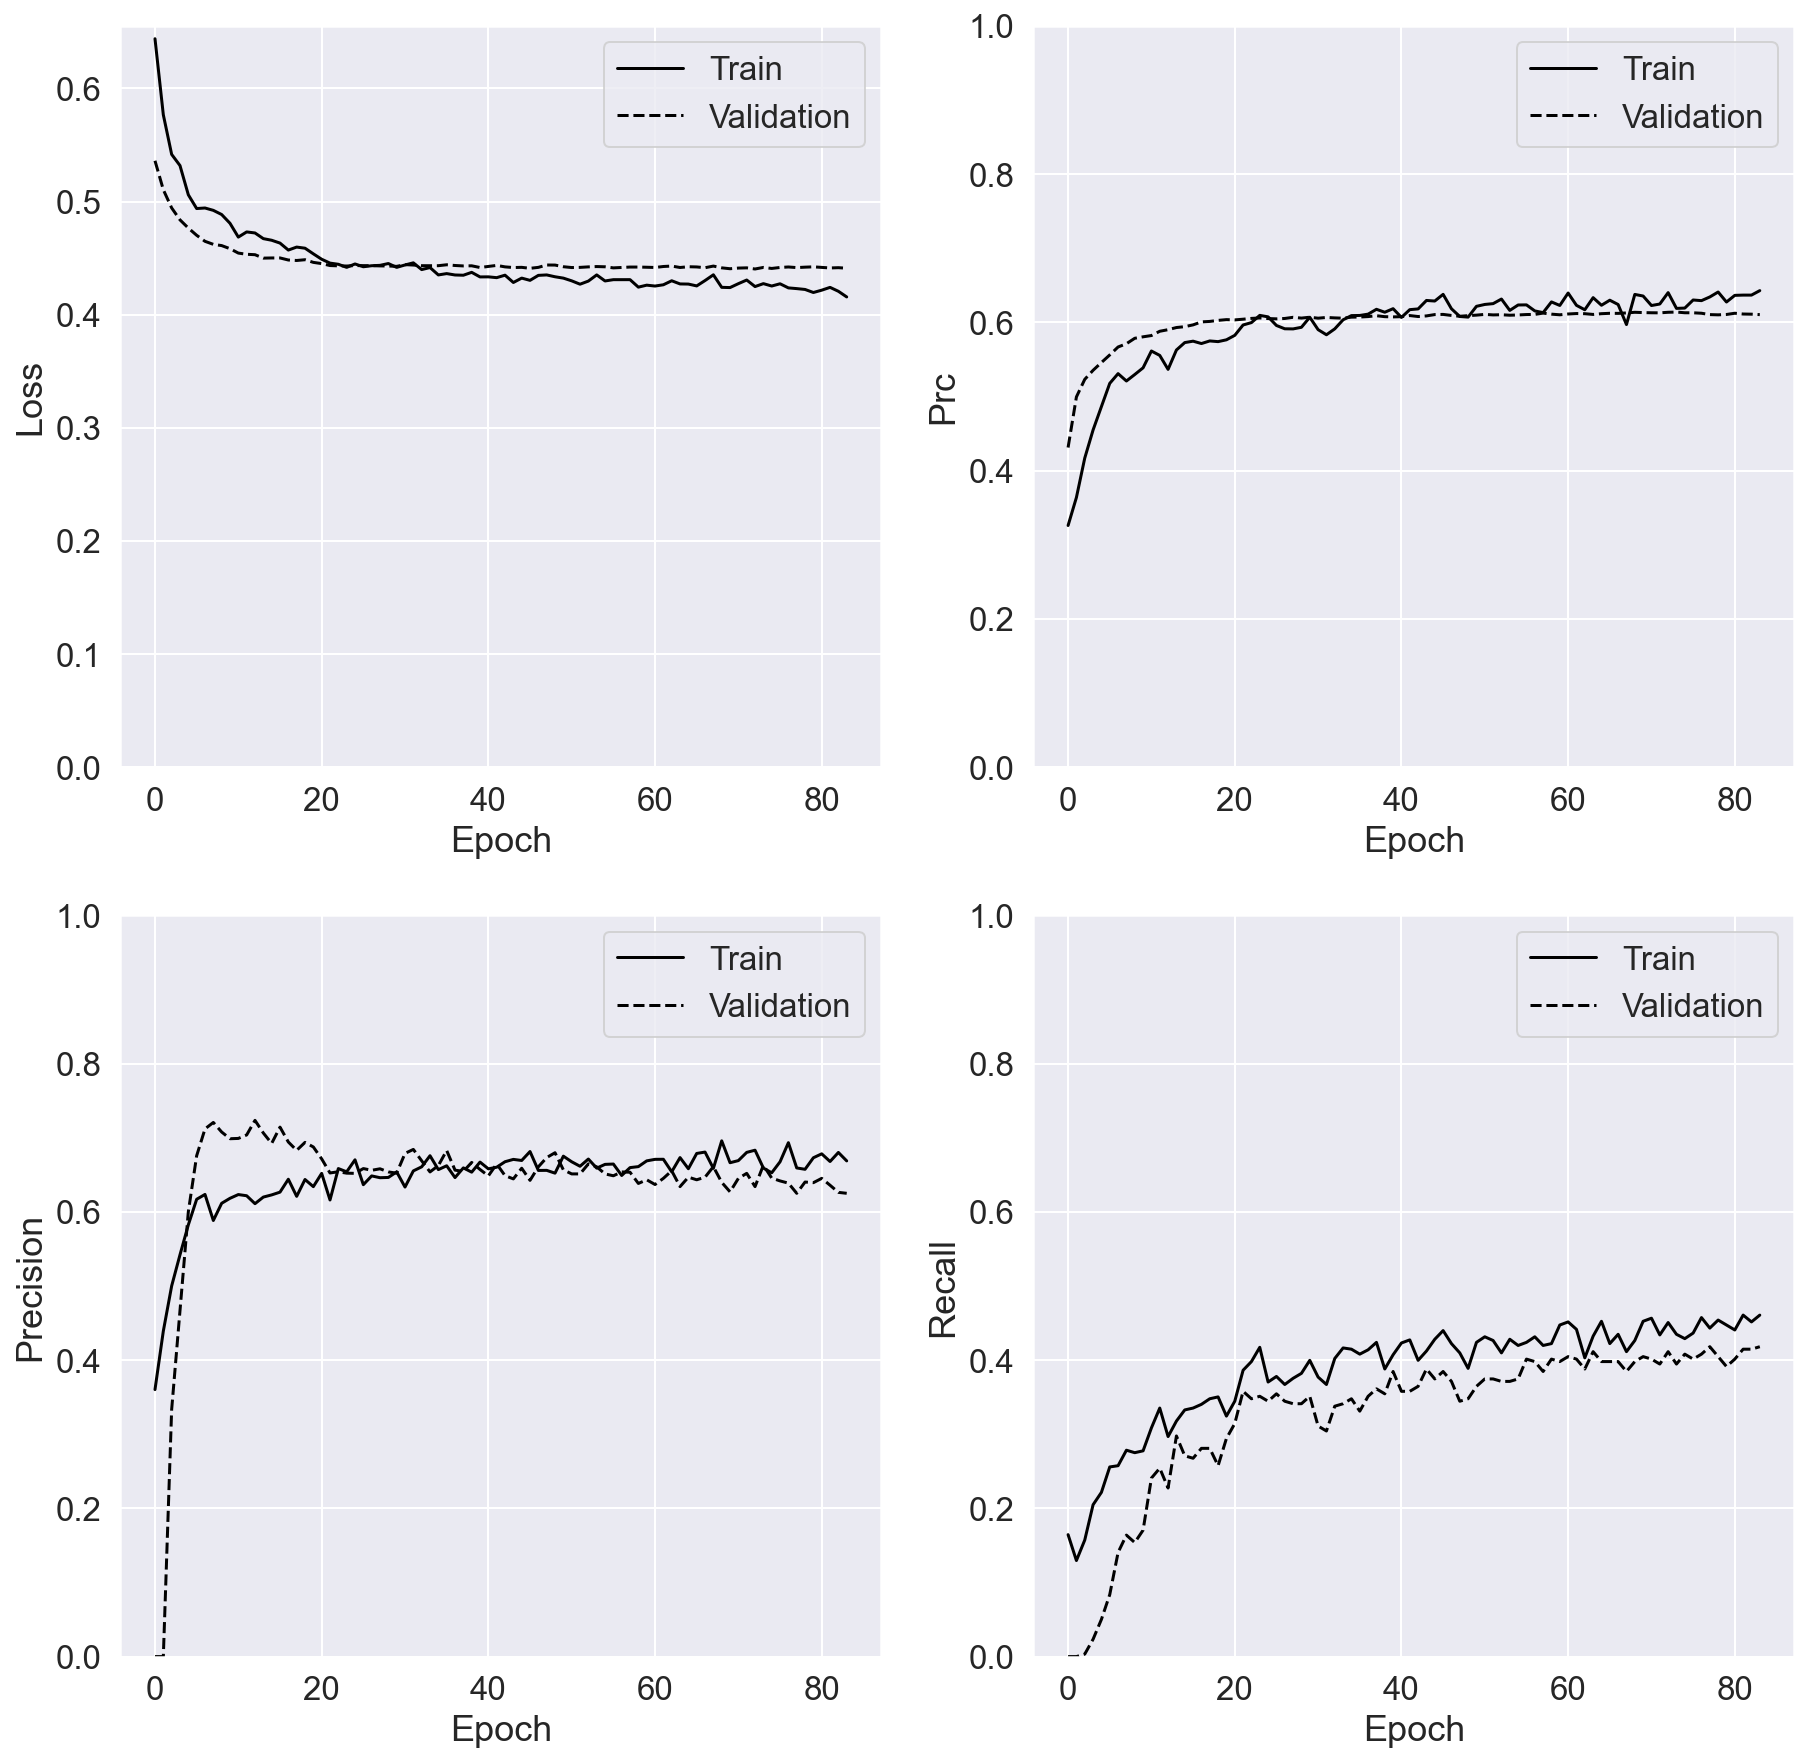

In [30]:
#plotting the Loss, PRC, Precision, and Recall
PlotMetrics(baseline_history)

In [31]:
#making predictions on train and test sets
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [32]:
#creating a function to plot the confusion matricx
def ConfMatrix(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

loss :  0.4203392267227173
tp :  160.0
fp :  61.0
tn :  972.0
fn :  214.0
accuracy :  0.8045486807823181
precision :  0.7239819169044495
recall :  0.427807480096817
auc :  0.8490197658538818
prc :  0.6749356985092163


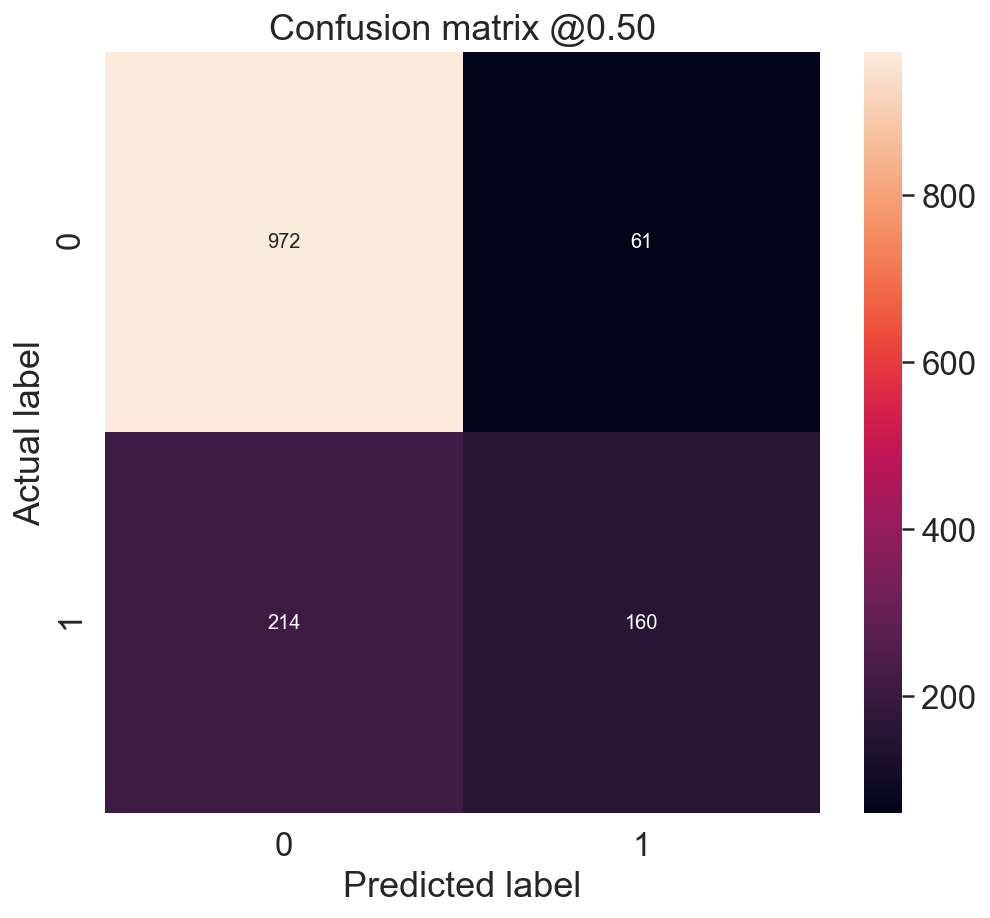

In [33]:
#calculating the model metrics and plotting the confusion matrix
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

ConfMatrix(test_labels, test_predictions_baseline)

In [34]:
#creating a function to plot the ROC
def PlotROC(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, lw=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 100.5])
    plt.ylim([-0.5, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

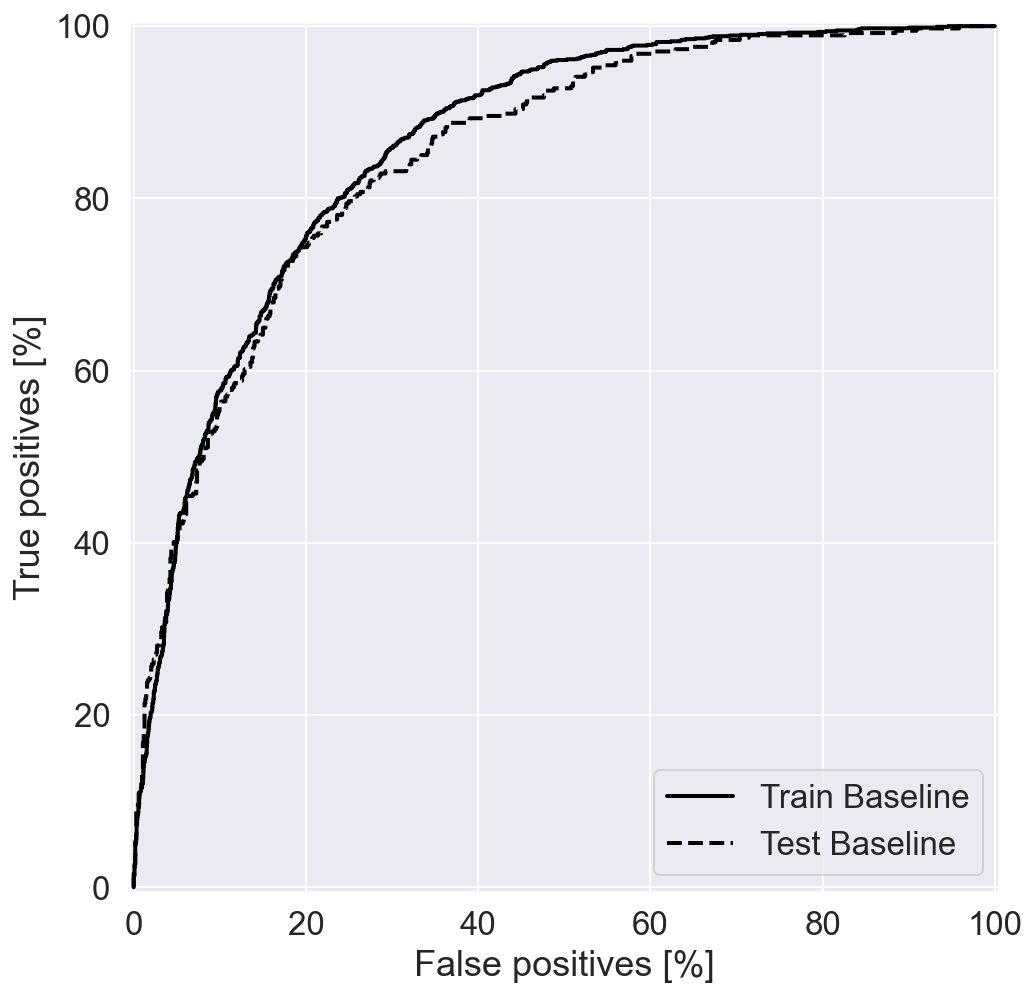

In [35]:
#plotting the ROC for train and test predictions
plt.figure(figsize=(8, 8))
PlotROC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotROC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')
plt.legend(loc='lower right')

In [36]:
#creating a function to plot the PRC
def PlotPRC(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, lw=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

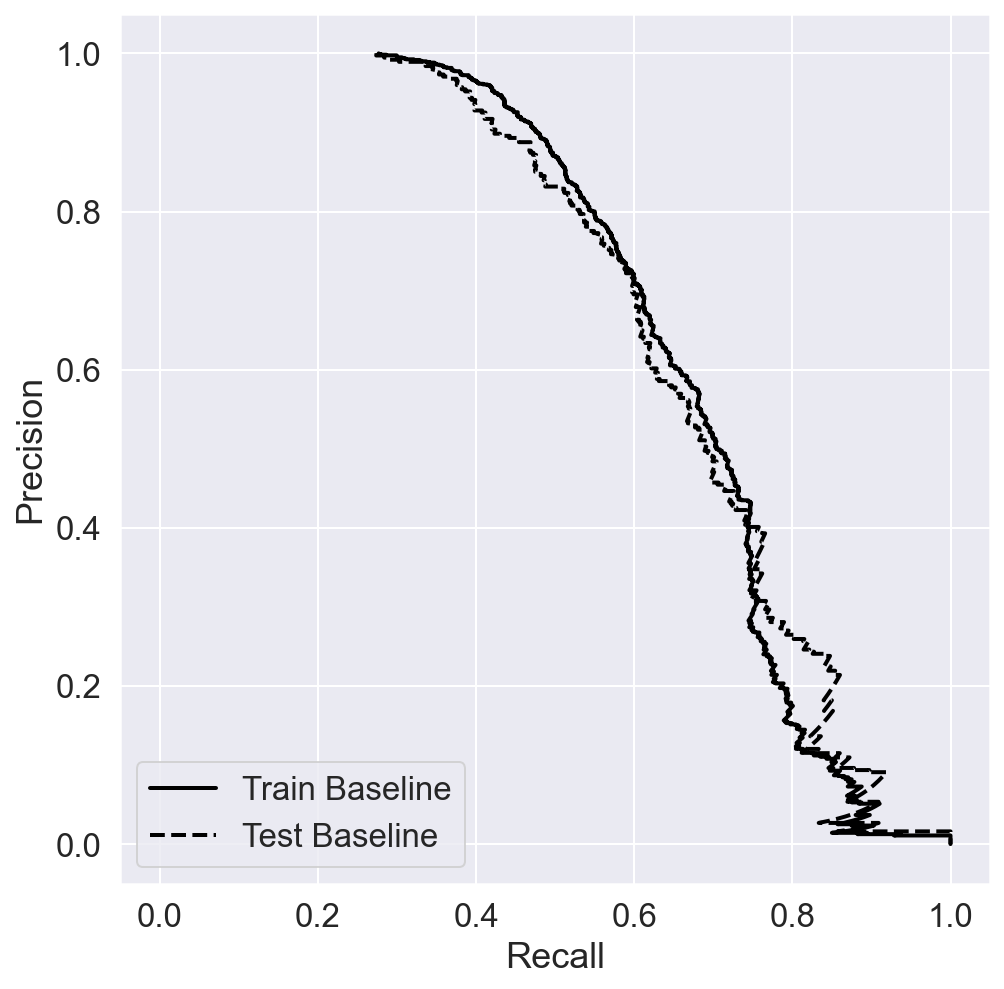

In [37]:
#plotting the PRC for train and test predictions
plt.figure(figsize=(8, 8))
PlotPRC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotPRC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')
plt.legend(loc='lower left')

Let's calcualte the weight for each class by multiplying the inverse of class population by half of total population.

In [38]:
#calculating class weights
weight_for_0 = (1/neg)*(total/2)
weight_for_1 = (1/pos)*(total/2)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.88


In [39]:
#creating and training a model using calculated initial weights and also class weights
weighted_model = make_model()
weighted_model.load_weights(initial_weights)
weighted_history = weighted_model.fit(train_features,
                                      train_labels,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      callbacks=[early_stopping],
                                      validation_data=(validation_features, validation_labels),
                                      class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
30/30 [==============================] - 2s 23ms/step - loss: 0.8383 - tp: 463.0000 - fp: 774.0000 - tn: 3563.0000 - fn: 1107.0000 - accuracy: 0.6816 - precision: 0.3743 - recall: 0.2949 - auc: 0.6299 - prc: 0.3330 - val_loss: 0.5651 - val_tp: 74.0000 - val_fp: 81.0000 - val_tn: 745.0000 - val_fn: 225.0000 - val_accuracy: 0.7280 - val_precision: 0.4774 - val_recall: 0.2475 - val_auc: 0.6851 - val_prc: 0.3930
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 0.7301 - tp: 489.0000 - fp: 874.0000 - tn: 2430.0000 - fn: 707.0000 - accuracy: 0.6487 - precision: 0.3588 - recall: 0.4089 - auc: 0.6224 - prc: 0.3531 - val_loss: 0.5554 - val_tp: 159.0000 - val_fp: 177.0000 - val_tn: 649.0000 - val_fn: 140.0000 - val_accuracy: 0.7182 - val_precision: 0.4732 - val_recall: 0.5318 - val_auc: 0.7500 - val_prc: 0.4762
Epoch 3/100
30

30/30 [==============================] - 0s 3ms/step - loss: 0.5364 - tp: 857.0000 - fp: 792.0000 - tn: 2512.0000 - fn: 339.0000 - accuracy: 0.7487 - precision: 0.5197 - recall: 0.7166 - auc: 0.8140 - prc: 0.5801 - val_loss: 0.5061 - val_tp: 214.0000 - val_fp: 186.0000 - val_tn: 640.0000 - val_fn: 85.0000 - val_accuracy: 0.7591 - val_precision: 0.5350 - val_recall: 0.7157 - val_auc: 0.8188 - val_prc: 0.6043
Epoch 20/100
30/30 [==============================] - 0s 2ms/step - loss: 0.5392 - tp: 842.0000 - fp: 764.0000 - tn: 2540.0000 - fn: 354.0000 - accuracy: 0.7516 - precision: 0.5243 - recall: 0.7040 - auc: 0.8142 - prc: 0.5790 - val_loss: 0.5036 - val_tp: 214.0000 - val_fp: 184.0000 - val_tn: 642.0000 - val_fn: 85.0000 - val_accuracy: 0.7609 - val_precision: 0.5377 - val_recall: 0.7157 - val_auc: 0.8196 - val_prc: 0.6066
Epoch 21/100
30/30 [==============================] - 0s 2ms/step - loss: 0.5342 - tp: 859.0000 - fp: 800.0000 - tn: 2504.0000 - fn: 337.0000 - accuracy: 0.7473 - pr

30/30 [==============================] - 0s 2ms/step - loss: 0.5156 - tp: 879.0000 - fp: 768.0000 - tn: 2536.0000 - fn: 317.0000 - accuracy: 0.7589 - precision: 0.5337 - recall: 0.7349 - auc: 0.8298 - prc: 0.6055 - val_loss: 0.4986 - val_tp: 220.0000 - val_fp: 186.0000 - val_tn: 640.0000 - val_fn: 79.0000 - val_accuracy: 0.7644 - val_precision: 0.5419 - val_recall: 0.7358 - val_auc: 0.8233 - val_prc: 0.6150
Epoch 39/100
30/30 [==============================] - 0s 2ms/step - loss: 0.5124 - tp: 875.0000 - fp: 748.0000 - tn: 2556.0000 - fn: 321.0000 - accuracy: 0.7624 - precision: 0.5391 - recall: 0.7316 - auc: 0.8305 - prc: 0.5938 - val_loss: 0.4996 - val_tp: 221.0000 - val_fp: 188.0000 - val_tn: 638.0000 - val_fn: 78.0000 - val_accuracy: 0.7636 - val_precision: 0.5403 - val_recall: 0.7391 - val_auc: 0.8236 - val_prc: 0.6154
Epoch 40/100
30/30 [==============================] - 0s 2ms/step - loss: 0.5073 - tp: 893.0000 - fp: 756.0000 - tn: 2548.0000 - fn: 303.0000 - accuracy: 0.7647 - pr

30/30 [==============================] - 0s 2ms/step - loss: 0.5013 - tp: 894.0000 - fp: 770.0000 - tn: 2534.0000 - fn: 302.0000 - accuracy: 0.7618 - precision: 0.5373 - recall: 0.7475 - auc: 0.8363 - prc: 0.6194 - val_loss: 0.5061 - val_tp: 220.0000 - val_fp: 200.0000 - val_tn: 626.0000 - val_fn: 79.0000 - val_accuracy: 0.7520 - val_precision: 0.5238 - val_recall: 0.7358 - val_auc: 0.8234 - val_prc: 0.6164
Epoch 58/100
30/30 [==============================] - 0s 2ms/step - loss: 0.5048 - tp: 912.0000 - fp: 778.0000 - tn: 2526.0000 - fn: 284.0000 - accuracy: 0.7640 - precision: 0.5396 - recall: 0.7625 - auc: 0.8365 - prc: 0.6087 - val_loss: 0.4977 - val_tp: 218.0000 - val_fp: 191.0000 - val_tn: 635.0000 - val_fn: 81.0000 - val_accuracy: 0.7582 - val_precision: 0.5330 - val_recall: 0.7291 - val_auc: 0.8231 - val_prc: 0.6172
Epoch 59/100
30/30 [==============================] - 0s 2ms/step - loss: 0.4973 - tp: 902.0000 - fp: 762.0000 - tn: 2542.0000 - fn: 294.0000 - accuracy: 0.7653 - pr

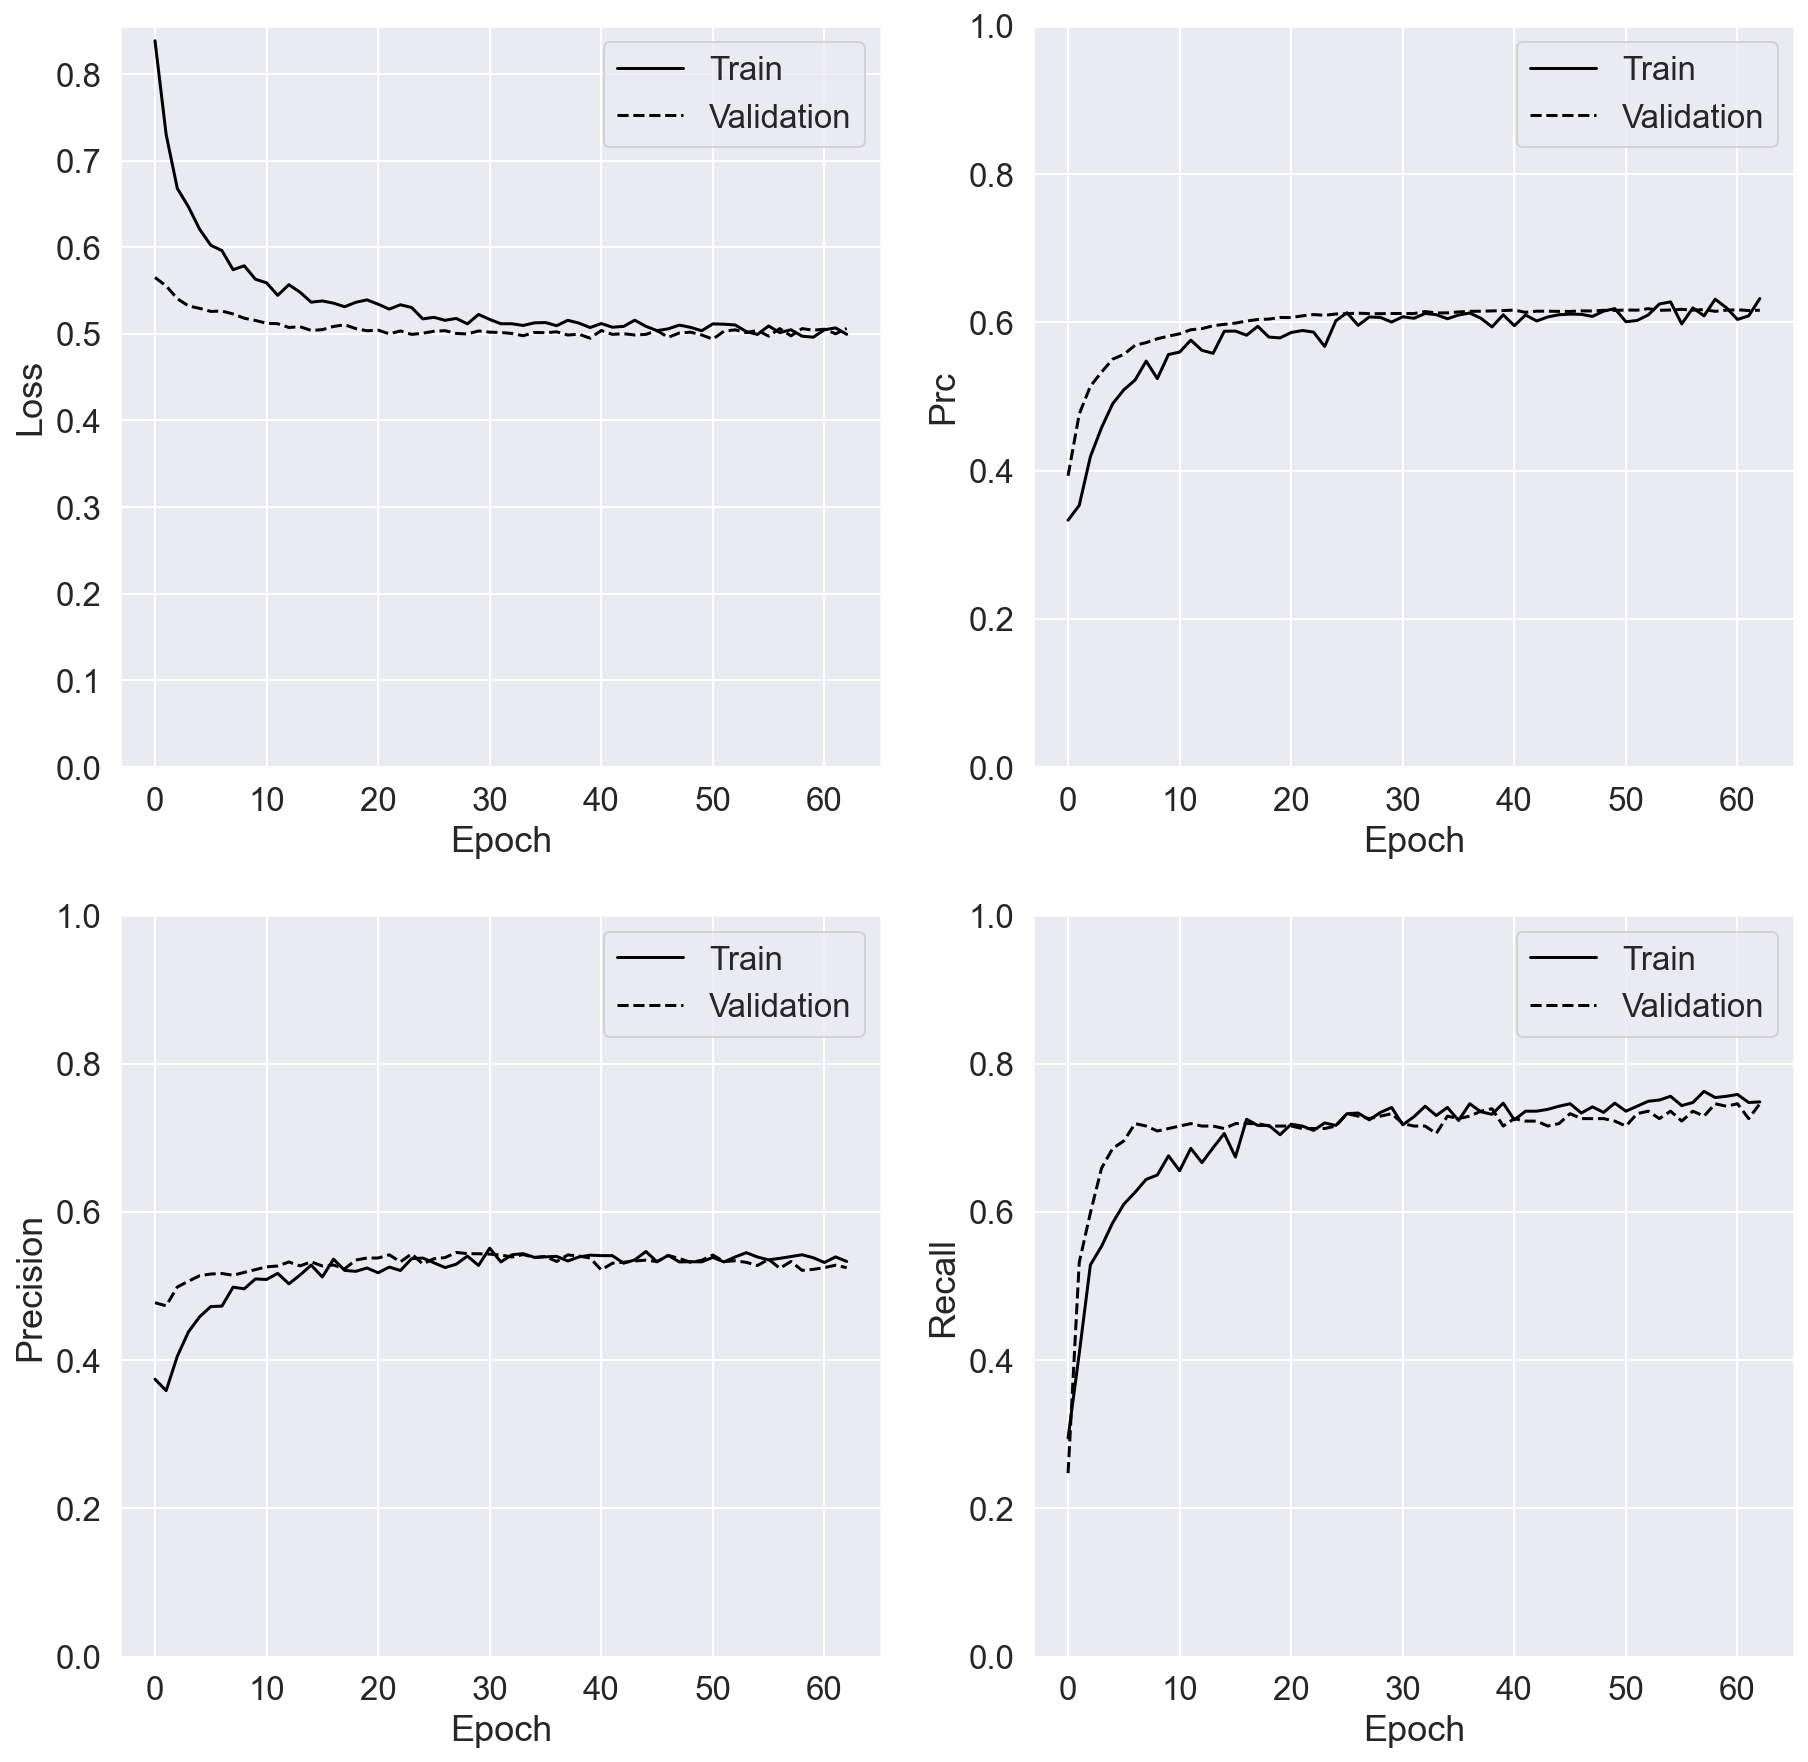

In [40]:
#plotting the evaluation metrics
PlotMetrics(weighted_history)

In [41]:
#making predictions on train and test sets
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.48090532422065735
tp :  295.0
fp :  242.0
tn :  791.0
fn :  79.0
accuracy :  0.7718549966812134
precision :  0.5493482351303101
recall :  0.7887700796127319
auc :  0.8471665382385254
prc :  0.6779568791389465


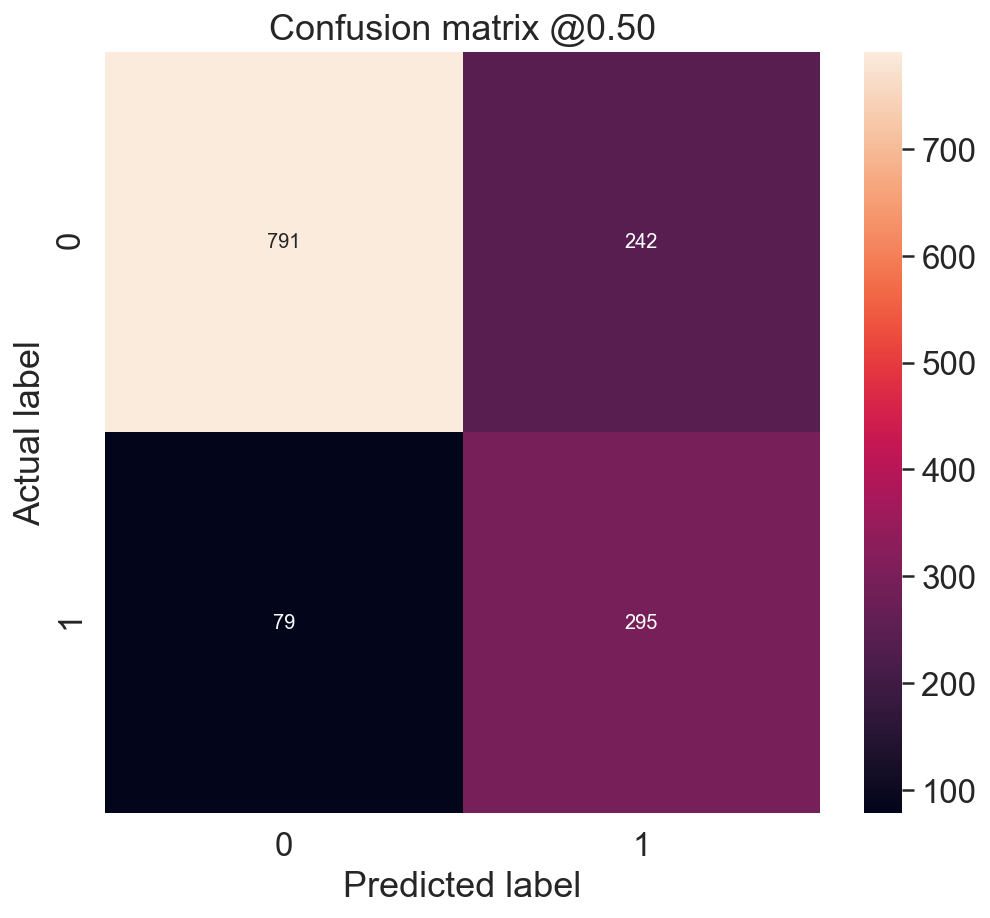

In [42]:
#calculating the model metrics and plotting the confusion matrix
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)

ConfMatrix(test_labels, test_predictions_weighted)

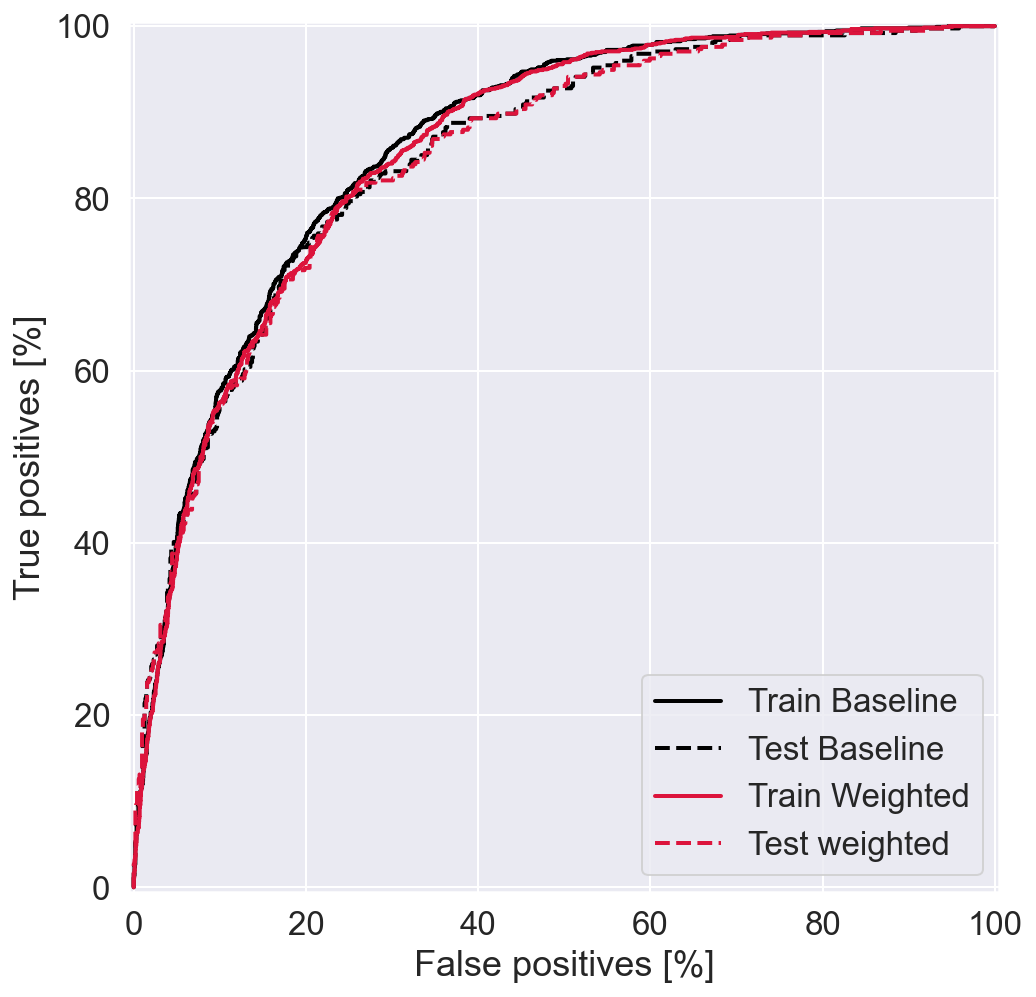

In [43]:
#plotting the ROC for both models to compare the effect of explicitly supplying the class weigths
plt.figure(figsize=(8, 8))

PlotROC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotROC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')

PlotROC('Train Weighted', train_labels, train_predictions_weighted, color='crimson')
PlotROC('Test weighted', test_labels, test_predictions_weighted, color='crimson', ls='--')

plt.legend(loc='lower right')

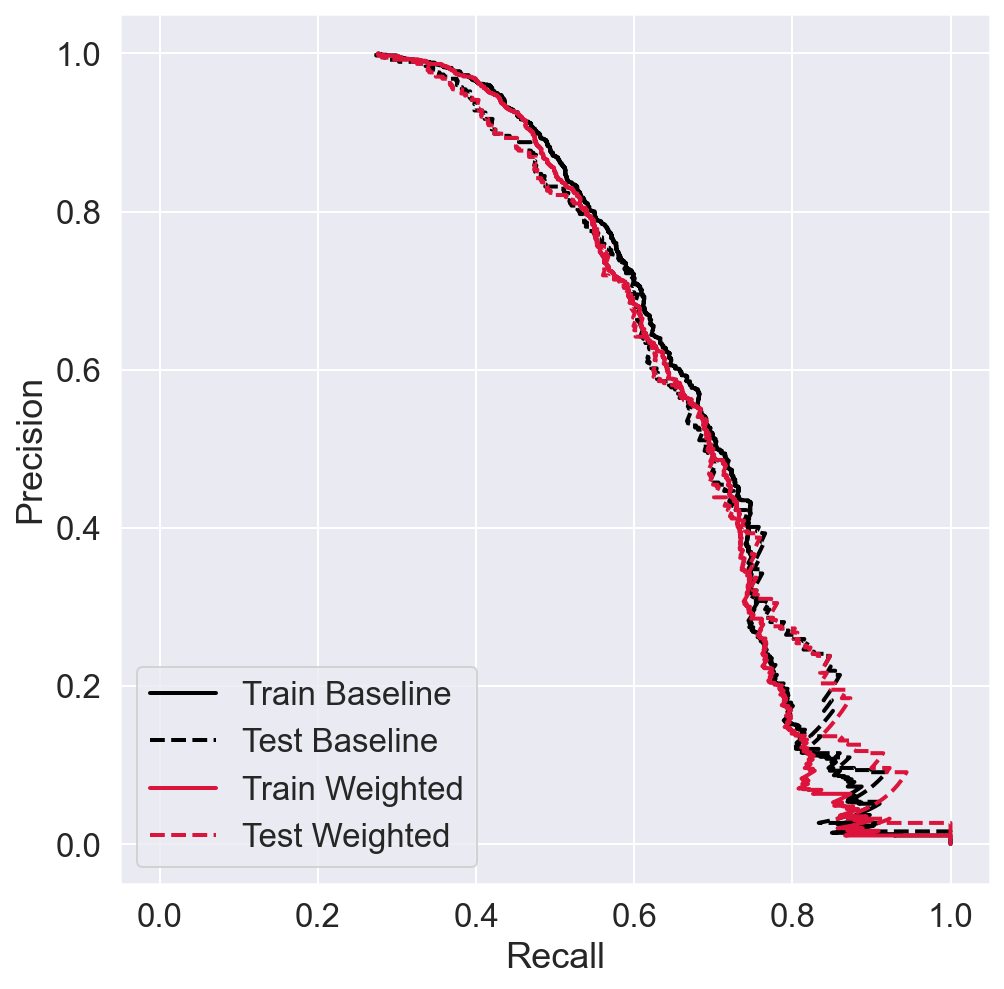

In [44]:
#plotting the PRC for both models to compare the effect of explicitly supplying the class weigths
plt.figure(figsize=(8, 8))

PlotPRC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotPRC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')

PlotPRC('Train Weighted', train_labels, train_predictions_weighted, color='crimson')
PlotPRC('Test Weighted', test_labels, test_predictions_weighted, color='crimson', ls='--')

plt.legend(loc='lower left')

Looking at these plots, it seems that supplying class weights doesn't have a noticable effect on either the ROC or PRC. Perhaps the present imbalance is not large enough to be significant.

Let's now look at one final metric, F1-beta score, as a way of comparing this neural network model with the more traditional models I trained in another [notebook](churn-predictor.ipynb).

In [45]:
#converting the probabilities to class predictions and calculating the F1-beta score
predicted_labels = test_predictions_weighted > 0.5
fbeta_score(test_labels, predicted_labels, beta=0.85, pos_label=1)

0.6294946203923366

Even though the difference isn't large, this score compares favourably with the one achieved by the <code>VotingClassifier</code>. It is also important to note that this score can potentially be improved upon by careful optimisation, something that hasn't been considered in this project and can be the basis of future work.